load library and dataset

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install statsmodels
import statsmodels.api as sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 86.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 16.6 MB/s eta 0:00:00


In [3]:
pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.9 MB/s eta 0:00:00


### Preprocessing Step by Step Showing

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_20230301.csv', engine='python')
# df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_20230302.csv', engine='python')
# df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_20230303.csv', engine='python')
# df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_20230304.csv', engine='python')

In [ ]:
df.head()

,O_ADMDONG_CD,D_ADMDONG_CD,ST_TIME_CD,FNS_TIME_CD,IN_FORN_DIV_NM,FORN_CITIZ_NM,MOVE_PURPOSE,MOVE_DIST,MOVE_TIME,CNT,ETL_YMD
0,11110515.0,11110515,0,0,단기외국인,ㆍ값없음,3,350.0,0.946667,3.50,20230302
1,11110515.0,11110515,0,0,내국인,ㆍ값없음,3,801.6,2.671667,2.74,20230302
2,11110515.0,11110515,0,0,내국인,한국,3,180.3,1.350000,4.13,20230302
3,11110515.0,11110540,0,0,내국인,ㆍ값없음,7,651.9,2.133333,2.48,20230302
4,11110515.0,11110550,0,0,단기외국인,ㆍ값없음,3,2220.9,7.146667,3.50,20230302


In [ ]:
# Drop rows where 'O_ADMDONG_CD' or 'D_ADMDONG_CD' is "\N" or blank
df = df[(df['O_ADMDONG_CD'] != '\\N') & (df['O_ADMDONG_CD'].notnull()) & (df['D_ADMDONG_CD'] != '\\N') & (df['D_ADMDONG_CD'].notnull())]

In [ ]:
df['O_ADMDONG_CD'] = df['O_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
df['D_ADMDONG_CD'] = df['D_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)

In [ ]:
df = df[(df['O_ADMDONG_CD'] != 0) & (df['D_ADMDONG_CD']!=0)]

In [ ]:
# df['O_ADMDONG_CD'].value_counts(dropna = False).to_frame().to_excel("/content/drive/MyDrive/FMC_Data/M-B_dong_202303/O_ADMDONG_CD_value_counts_0304_after_process2.xlsx")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11113762 entries, 0 to 11113996
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   O_ADMDONG_CD    int64  
 1   D_ADMDONG_CD    int64  
 2   ST_TIME_CD      int64  
 3   FNS_TIME_CD     int64  
 4   IN_FORN_DIV_NM  object 
 5   FORN_CITIZ_NM   object 
 6   MOVE_PURPOSE    int64  
 7   MOVE_DIST       float64
 8   MOVE_TIME       float64
 9   CNT             float64
 10  ETL_YMD         int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 1017.5+ MB


1: Going to Work, 2 : Going to School, 3: Going back to home, 4: Shopping, 5: Sightseeing/Tourism, 6: Hospital, 7: Others

In [ ]:
# Add product MOVE_DIST & MOVE_TIME
# Calculate the new variable and add it as a new column
df['MOVE_DISTxCNT'] = df['MOVE_DIST'] * df['CNT']
df['MOVE_TIMExCNT'] = df['MOVE_TIME'] * df['CNT']

In [ ]:
# Filter the purpose
df_24567 = df[df['MOVE_PURPOSE'].isin([2, 4, 5, 6, 7])]
df_1 = df[df['MOVE_PURPOSE']==1]
df_3 = df[df['MOVE_PURPOSE'] == 3]

In [ ]:
# Aggregate the dataset
# Aggregating purpose 2,4,5,6,7 (all except going to work(1) and coming back to home(3)) trip
aggregated_df_24567 = df_24567.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
    'CNT': 'sum',
    'MOVE_DISTxCNT': 'sum',
    'MOVE_TIMExCNT': 'sum'
}).reset_index()

# Aggregating purpose 1 (going to work) trip
aggregated_df_1 = df_1.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
    'CNT': 'sum',
    'MOVE_DISTxCNT': 'sum',
    'MOVE_TIMExCNT': 'sum'
}).reset_index()

In [ ]:
# Merge the two aggregated DataFrames on ['O_ADMDONG_CD', 'D_ADMDONG_CD']
merged_df = pd.merge(aggregated_df_24567, aggregated_df_1, on=['O_ADMDONG_CD', 'D_ADMDONG_CD'], suffixes=('_24567', '_1'), how='left')

# Fill NaN values with 0 (in case there are no purpose 1 trips for some O-D pairs)
merged_df = merged_df.fillna(0)

In [ ]:
#@title Calculate the return trips after all non-work visits (RT-NonWork)
# Calculate the return trips after all non-work visits (RT-NonWork)
merged_df['RT-NonWork_CNT'] = merged_df['CNT_24567'] - merged_df['CNT_1']
merged_df['RT-NonWork_MOVE_DISTxCNT'] = merged_df['MOVE_DISTxCNT_24567'] - merged_df['MOVE_DISTxCNT_1']
merged_df['RT-NonWork_MOVE_TIMExCNT'] = merged_df['MOVE_TIMExCNT_24567'] - merged_df['MOVE_TIMExCNT_1']

In [ ]:
#@title Aggregating purpose 3 (coming back to home) trip
aggregated_df_3 = df_3.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
    'CNT': 'sum',
    'MOVE_DISTxCNT': 'sum',
    'MOVE_TIMExCNT': 'sum'
}).reset_index()

# Rename columns to add the _3 suffix
aggregated_df_3.rename(columns={
    'CNT': 'CNT_3',
    'MOVE_DISTxCNT': 'MOVE_DISTxCNT_3',
    'MOVE_TIMExCNT': 'MOVE_TIMExCNT_3'
}, inplace=True)

# Merge the aggregated_df_3 with the merged_df that contains RT-NonWork data
final_merged_df = pd.merge(merged_df, aggregated_df_3, on=['O_ADMDONG_CD', 'D_ADMDONG_CD'], how='left')

# Fill NaN values with 0 (in case there are no purpose 3 trips for some O-D pairs)
final_merged_df = final_merged_df.fillna(0)

# Calculate the going home after work trips (RT-Work)
final_merged_df['RT-Work_CNT'] = final_merged_df['CNT_3'] - final_merged_df['RT-NonWork_CNT']
final_merged_df['RT-Work_MOVE_DISTxCNT'] = final_merged_df['MOVE_DISTxCNT_3'] - final_merged_df['RT-NonWork_MOVE_DISTxCNT']
final_merged_df['RT-Work_MOVE_TIMExCNT'] = final_merged_df['MOVE_TIMExCNT_3'] - final_merged_df['RT-NonWork_MOVE_TIMExCNT']

# Select relevant columns for the final DataFrame
final_df = final_merged_df[['O_ADMDONG_CD', 'D_ADMDONG_CD', 'CNT_24567', 'CNT_1', 'MOVE_DISTxCNT_24567', 'MOVE_DISTxCNT_1', 'MOVE_TIMExCNT_24567', 'MOVE_TIMExCNT_1', 'RT-NonWork_CNT', 'RT-NonWork_MOVE_DISTxCNT', 'RT-NonWork_MOVE_TIMExCNT', 'CNT_3', 'MOVE_DISTxCNT_3', 'MOVE_TIMExCNT_3', 'RT-Work_CNT', 'RT-Work_MOVE_DISTxCNT', 'RT-Work_MOVE_TIMExCNT']]

# Reorder the columns in the final DataFrame
final_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD', 'CNT_1', 'CNT_3', 'CNT_24567',
                     'MOVE_DISTxCNT_1', 'MOVE_DISTxCNT_3', 'MOVE_DISTxCNT_24567',
                     'MOVE_TIMExCNT_1', 'MOVE_TIMExCNT_3', 'MOVE_TIMExCNT_24567',
                     'RT-NonWork_CNT', 'RT-NonWork_MOVE_DISTxCNT', 'RT-NonWork_MOVE_TIMExCNT',
                     'RT-Work_CNT', 'RT-Work_MOVE_DISTxCNT', 'RT-Work_MOVE_TIMExCNT']]

# add and work trip-related columns and non-work trip-related columns separately
count_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD','CNT_1', 'CNT_3', 'CNT_24567', 'RT-NonWork_CNT', 'RT-Work_CNT']]
work_related_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD', 'CNT_1', 'MOVE_DISTxCNT_1', 'MOVE_TIMExCNT_1', 'RT-Work_CNT', 'RT-Work_MOVE_DISTxCNT', 'RT-Work_MOVE_TIMExCNT']]

##### exporting file examples

In [ ]:
# # save the final DataFrame to a new CSV file
# final_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_2)Dist_3)Time_230301.csv', index=False)
# final_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_2)Dist_3)Time_230302.csv', index=False)
# final_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_2)Dist_3)Time_230303.csv', index=False)
# final_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_2)Dist_3)Time_230304.csv', index=False)

In [ ]:
# count_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_230301.csv', index=False)
# count_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_230302.csv', index=False)
# count_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_230303.csv', index=False)
# count_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_OD_1)Numtrip_230304.csv', index=False)

In [ ]:
# work_related_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_Work_OD_230301.csv', index=False)
# work_related_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_Work_OD_230302.csv', index=False)
# work_related_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_Work_OD_230303.csv', index=False)
# work_related_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_Dong_Work_OD_230304.csv', index=False)

### Preprocessing code (Loop)

In [ ]:
# Define the file path template
path_template = "/content/drive/MyDrive/FMC_Data/M-B_dong_202303/seoul_purpose_admdong3_202303{:02d}.csv"
output_path_template = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated count dist time each day_2/Aggregated_Dong_OD_1)Numtrip_2)Dist_3)Time_2303{:02d}.csv"
count_output_path_template = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_count_each day_2/Aggregated_Dong_OD_1)Numtrip_2303{:02d}.csv"
work_output_path_template = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_work_each day_2/Aggregated_Dong_Work_OD_2303{:02d}.csv"

# Loop over the files
for day in range(1, 32):  # Assuming files are numbered from 01 to 31
    path = path_template.format(day)
    df = pd.read_csv(path, engine='python')

    # preprocessing steps
    # Drop rows where 'O_ADMDONG_CD' or 'D_ADMDONG_CD' is "\N" or blank
    df = df[(df['O_ADMDONG_CD'] != '\\N') & (df['O_ADMDONG_CD'].notnull()) & (df['D_ADMDONG_CD'] != '\\N') & (df['D_ADMDONG_CD'].notnull())]
    df['O_ADMDONG_CD'] = df['O_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int) # df.loc[:, 'O_ADMDONG_CD']
    df['D_ADMDONG_CD'] = df['D_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int) # df.loc[:, 'D_ADMDONG_CD']
    df = df[(df['O_ADMDONG_CD'] != 0) & (df['D_ADMDONG_CD']!=0)]

    # Add product MOVE_DIST & MOVE_TIME
    # Calculate the new variable and add it as a new column
    df['MOVE_DISTxCNT'] = df['MOVE_DIST'] * df['CNT']
    df['MOVE_TIMExCNT'] = df['MOVE_TIME'] * df['CNT']

    # Filter the purpose
    df_24567 = df[df['MOVE_PURPOSE'].isin([2, 4, 5, 6, 7])]
    df_1 = df[df['MOVE_PURPOSE']==1]
    df_3 = df[df['MOVE_PURPOSE'] == 3]

    # Aggregate the dataset
    # Aggregating purpose 2,4,5,6,7 (all except going to work(1) and coming back to home(3)) trip
    aggregated_df_24567 = df_24567.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
        'CNT': 'sum',
        'MOVE_DISTxCNT': 'sum',
        'MOVE_TIMExCNT': 'sum'
    }).reset_index()

    # Aggregating purpose 1 (going to work) trip
    aggregated_df_1 = df_1.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
        'CNT': 'sum',
        'MOVE_DISTxCNT': 'sum',
        'MOVE_TIMExCNT': 'sum'
    }).reset_index()

    # Merge the two aggregated DataFrames on ['O_ADMDONG_CD', 'D_ADMDONG_CD']
    merged_df = pd.merge(aggregated_df_24567, aggregated_df_1, on=['O_ADMDONG_CD', 'D_ADMDONG_CD'], suffixes=('_24567', '_1'), how='left')

    # Fill NaN values with 0 (in case there are no purpose 1 trips for some O-D pairs)
    merged_df = merged_df.fillna(0)

    # Calculate the return trips after all non-work visits (RT-NonWork)
    merged_df['RT-NonWork_CNT'] = merged_df['CNT_24567'] - merged_df['CNT_1']
    merged_df.loc[merged_df['RT-NonWork_CNT'] < 0, 'RT-NonWork_CNT'] = 0
    merged_df['RT-NonWork_MOVE_DISTxCNT'] = merged_df['MOVE_DISTxCNT_24567'] - merged_df['MOVE_DISTxCNT_1']
    merged_df.loc[merged_df['RT-NonWork_MOVE_DISTxCNT'] < 0, 'RT-NonWork_MOVE_DISTxCNT'] = 0
    merged_df['RT-NonWork_MOVE_TIMExCNT'] = merged_df['MOVE_TIMExCNT_24567'] - merged_df['MOVE_TIMExCNT_1']
    merged_df.loc[merged_df['RT-NonWork_MOVE_TIMExCNT'] < 0, 'RT-NonWork_MOVE_TIMExCNT'] = 0

    # Aggregating purpose 3 (coming back to home) trip
    aggregated_df_3 = df_3.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
        'CNT': 'sum',
        'MOVE_DISTxCNT': 'sum',
        'MOVE_TIMExCNT': 'sum'
    }).reset_index()

    # Rename columns to add the _3 suffix
    aggregated_df_3.rename(columns={
        'CNT': 'CNT_3',
        'MOVE_DISTxCNT': 'MOVE_DISTxCNT_3',
        'MOVE_TIMExCNT': 'MOVE_TIMExCNT_3'
    }, inplace=True)

    # Merge the aggregated_df_3 with the merged_df that contains RT-NonWork data
    final_merged_df = pd.merge(merged_df, aggregated_df_3, on=['O_ADMDONG_CD', 'D_ADMDONG_CD'], how='left')

    # Fill NaN values with 0 (in case there are no purpose 3 trips for some O-D pairs)
    final_merged_df = final_merged_df.fillna(0)

    # Calculate the going home after work trips (RT-Work)
    final_merged_df['RT-Work_CNT'] = final_merged_df['CNT_3'] - final_merged_df['RT-NonWork_CNT']
    final_merged_df['RT-Work_MOVE_DISTxCNT'] = final_merged_df['MOVE_DISTxCNT_3'] - final_merged_df['RT-NonWork_MOVE_DISTxCNT']
    final_merged_df['RT-Work_MOVE_TIMExCNT'] = final_merged_df['MOVE_TIMExCNT_3'] - final_merged_df['RT-NonWork_MOVE_TIMExCNT']

    # Select relevant columns for the final DataFrame
    final_df = final_merged_df[['O_ADMDONG_CD', 'D_ADMDONG_CD', 'CNT_24567', 'CNT_1', 'MOVE_DISTxCNT_24567', 'MOVE_DISTxCNT_1', 'MOVE_TIMExCNT_24567', 'MOVE_TIMExCNT_1', 'RT-NonWork_CNT', 'RT-NonWork_MOVE_DISTxCNT', 'RT-NonWork_MOVE_TIMExCNT', 'CNT_3', 'MOVE_DISTxCNT_3', 'MOVE_TIMExCNT_3', 'RT-Work_CNT', 'RT-Work_MOVE_DISTxCNT', 'RT-Work_MOVE_TIMExCNT']]

    # Reorder the columns in the final DataFrame
    final_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD', 'CNT_1', 'CNT_3', 'CNT_24567',
                        'MOVE_DISTxCNT_1', 'MOVE_DISTxCNT_3', 'MOVE_DISTxCNT_24567',
                        'MOVE_TIMExCNT_1', 'MOVE_TIMExCNT_3', 'MOVE_TIMExCNT_24567',
                        'RT-NonWork_CNT', 'RT-NonWork_MOVE_DISTxCNT', 'RT-NonWork_MOVE_TIMExCNT',
                        'RT-Work_CNT', 'RT-Work_MOVE_DISTxCNT', 'RT-Work_MOVE_TIMExCNT']]

    # add and work trip-related columns and non-work trip-related columns separately
    count_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD','CNT_1', 'CNT_3', 'CNT_24567', 'RT-NonWork_CNT', 'RT-Work_CNT']]
    work_related_df = final_df[['O_ADMDONG_CD', 'D_ADMDONG_CD', 'CNT_1', 'MOVE_DISTxCNT_1', 'MOVE_TIMExCNT_1', 'RT-Work_CNT', 'RT-Work_MOVE_DISTxCNT', 'RT-Work_MOVE_TIMExCNT']]

    # Save the final DataFrames
    output_path = output_path_template.format(day)
    count_output_path = count_output_path_template.format(day)
    work_output_path = work_output_path_template.format(day)
    final_df.to_csv(output_path, index=False)
    count_df.to_csv(count_output_path, index=False)
    work_related_df.to_csv(work_output_path, index=False)

<ipython-input-3-ad231ca5bdd0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['O_ADMDONG_CD'] = df['O_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
<ipython-input-3-ad231ca5bdd0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['O_ADMDONG_CD'] = df['O_ADMDONG_CD'].fillna(0).infer_objects(copy=False).astype(int)
<ipython-input-3-ad231ca5bdd0>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

### Concatenating Codes


#### load aggregated Num Dist Time data and combine those

In [ ]:
# Define the file path template
path_template = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated count dist time each day_2/Aggregated_Dong_OD_1)Numtrip_2)Dist_3)Time_2303{:02d}.csv"

# Create a list to store all data frames
df_list = []

# Loop over the files
for day in range(1, 32):  # Assuming files are numbered from 01 to 31
    path = path_template.format(day)
    df = pd.read_csv(path, engine='python')
    df_list.append(df)  # Add the current data frame to the list

In [ ]:
# Loop over the list and print the data type of 'O_ADMDONG_CD' and 'D_ADMDONG_CD'
for i, df in enumerate(df_list, start=1):
    print(f"DataFrame df{i}:")
    print(f"O_ADMDONG_CD dtype: {df['O_ADMDONG_CD'].dtype}")
    print(f"D_ADMDONG_CD dtype: {df['D_ADMDONG_CD'].dtype}")
    print()

DataFrame df1:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df2:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df3:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df4:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df5:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df6:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df7:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df8:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df9:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df10:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df11:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df12:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df13:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df14:
O_ADMDONG_CD dtype: int64
D_ADMDONG_CD dtype: int64

DataFrame df15:
O_ADMDONG_CD dtype: int64
D

In [ ]:
# Concatenate all the DataFrames in the list
big_df_noNan = pd.concat(df_list, ignore_index=True)

In [ ]:
# Check for the presence of '\\N'
contains_N = '\\N' in big_df_noNan['O_ADMDONG_CD'].values

# Print the results
print(f"Contains '\\N': {contains_N}")

Contains '\N': False


In [ ]:
# Check for the presence of '\\N'
contains_N = '\\N' in big_df_noNan['D_ADMDONG_CD'].values

# Print the results
print(f"Contains '\\N': {contains_N}")

Contains '\N': False


In [ ]:
# Aggregate each column by 'O_ADMDONG_CD' and 'D_ADMDONG_CD'
aggregated_df = big_df_noNan.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
    'CNT_1': 'sum',
    'CNT_3': 'sum',
    'CNT_24567': 'sum',
    'MOVE_DISTxCNT_1': 'sum',
    'MOVE_DISTxCNT_3': 'sum',
    'MOVE_DISTxCNT_24567': 'sum',
    'MOVE_TIMExCNT_1': 'sum',
    'MOVE_TIMExCNT_3': 'sum',
    'MOVE_TIMExCNT_24567': 'sum',
    'RT-NonWork_CNT': 'sum',
    'RT-NonWork_MOVE_DISTxCNT': 'sum',
    'RT-NonWork_MOVE_TIMExCNT': 'sum',
    'RT-Work_CNT': 'sum',
    'RT-Work_MOVE_DISTxCNT': 'sum',
    'RT-Work_MOVE_TIMExCNT': 'sum'
}).reset_index()

# Calculate the Average distance and times
aggregated_df['Avg_DIST_1'] = aggregated_df['MOVE_DISTxCNT_1']/aggregated_df['CNT_1']
aggregated_df['Avg_DIST_3'] = aggregated_df['MOVE_DISTxCNT_3']/aggregated_df['CNT_3']
aggregated_df['Avg_DIST_24567'] = aggregated_df['MOVE_DISTxCNT_24567']/aggregated_df['CNT_24567']
aggregated_df['Avg_RT_NonWork_DIST'] = aggregated_df['RT-NonWork_MOVE_DISTxCNT']/aggregated_df['RT-NonWork_CNT']
aggregated_df['Avg_RT_Work_DIST'] = aggregated_df['RT-Work_MOVE_DISTxCNT']/aggregated_df['RT-Work_CNT']

aggregated_df['Avg_TIME_1'] = aggregated_df['MOVE_TIMExCNT_1']/aggregated_df['CNT_1']
aggregated_df['Avg_TIME_3'] = aggregated_df['MOVE_TIMExCNT_3']/aggregated_df['CNT_3']
aggregated_df['Avg_TIME_24567'] = aggregated_df['MOVE_TIMExCNT_24567']/aggregated_df['CNT_24567']
aggregated_df['Avg_RT_NonWork_TIME'] = aggregated_df['RT-NonWork_MOVE_TIMExCNT']/aggregated_df['RT-NonWork_CNT']
aggregated_df['Avg_RT_Work_TIME'] = aggregated_df['RT-Work_MOVE_TIMExCNT']/aggregated_df['RT-Work_CNT']

In [ ]:
# save the aggregated DataFrame to a new CSV file
aggregated_df.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/aggregated_COUNT_Dong-Dong count dist time_2023_03_ver2.csv', index=False)

In [ ]:
aggregated_df.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,CNT_3,CNT_24567,MOVE_DISTxCNT_1,MOVE_DISTxCNT_3,MOVE_DISTxCNT_24567,MOVE_TIMExCNT_1,MOVE_TIMExCNT_3,...,Avg_DIST_1,Avg_DIST_3,Avg_DIST_24567,Avg_RT_NonWork_DIST,Avg_RT_Work_DIST,Avg_TIME_1,Avg_TIME_3,Avg_TIME_24567,Avg_RT_NonWork_TIME,Avg_RT_Work_TIME
0,11110515,11110515,13045.84,52744.40,139766.81,5.762448e+06,2.384616e+07,7.622389e+07,202241.584854,935913.259475,...,441.707717,452.107828,545.364764,556.036188,630.135852,15.502381,17.744315,16.657959,16.776925,16.087187
1,11110515,11110530,11888.65,12368.02,108223.86,1.093979e+07,9.636553e+06,9.889134e+07,196172.996056,272984.440617,...,920.188156,779.150815,913.766482,912.973988,932.685588,16.500864,22.071798,22.247274,22.956434,23.086737
2,11110515,11110540,1498.43,2483.60,27594.13,1.694384e+06,2.434766e+06,2.791596e+07,34178.196937,47006.789224,...,1130.772783,980.337236,1011.662876,1004.823518,1007.399067,22.809338,18.926876,23.287716,23.315185,23.776762
3,11110515,11110550,1207.86,12662.17,14987.79,2.321612e+06,2.502406e+07,2.602437e+07,30283.334936,340036.886143,...,1922.087022,1976.284891,1736.371488,1720.092859,-1182.092825,25.071892,26.854551,22.120367,21.861655,-34.698690
4,11110515,11110560,1033.45,12025.93,7057.94,3.155446e+06,3.440110e+07,2.041584e+07,25791.165847,382875.122837,...,3053.313100,2860.576771,2892.606538,2865.038695,2856.097710,24.956375,31.837465,28.564834,29.183835,34.501287


In [ ]:
aggregated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3204373 entries, 0 to 3204372
Data columns (total 27 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   O_ADMDONG_CD              int64  
 1   D_ADMDONG_CD              int64  
 2   CNT_1                     float64
 3   CNT_3                     float64
 4   CNT_24567                 float64
 5   MOVE_DISTxCNT_1           float64
 6   MOVE_DISTxCNT_3           float64
 7   MOVE_DISTxCNT_24567       float64
 8   MOVE_TIMExCNT_1           float64
 9   MOVE_TIMExCNT_3           float64
 10  MOVE_TIMExCNT_24567       float64
 11  RT-NonWork_CNT            float64
 12  RT-NonWork_MOVE_DISTxCNT  float64
 13  RT-NonWork_MOVE_TIMExCNT  float64
 14  RT-Work_CNT               float64
 15  RT-Work_MOVE_DISTxCNT     float64
 16  RT-Work_MOVE_TIMExCNT     float64
 17  Avg_DIST_1                float64
 18  Avg_DIST_3                float64
 19  Avg_DIST_24567            float64
 20  Avg_RT_NonWork_DIST     

#### count data frame concatenating

In [ ]:
# 1)NumTrip만 있는 데이터
# Define the file path template
path_template_1 = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_count_each day_2/Aggregated_Dong_OD_1)Numtrip_2303{:02d}.csv"

# Create a list to store all data frames
df_list_count_dfs = []

# Loop over the files
for day in range(1, 32):  # Assuming files are numbered from 01 to 31
    path = path_template_1.format(day)
    df = pd.read_csv(path, engine='python')
    df_list_count_dfs.append(df)  # Add the current data frame to the list

In [ ]:
# Concatenate all the DataFrames in the list
big_df_noNan_count = pd.concat(df_list_count_dfs, ignore_index=True)

In [ ]:
big_df_noNan_count.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,CNT_3,CNT_24567,RT-NonWork_CNT,RT-Work_CNT
0,11110515,11110515,284.56,1368.74,4820.87,4536.31,-3167.57
1,11110515,11110530,178.83,360.70,4323.70,4144.87,-3784.17
2,11110515,11110540,27.04,78.61,1313.01,1285.97,-1207.36
3,11110515,11110550,8.00,212.45,555.20,547.20,-334.75
4,11110515,11110560,10.86,247.46,181.50,170.64,76.82


In [ ]:
# Aggregate each column by 'O_ADMDONG_CD' and 'D_ADMDONG_CD'
aggregated_df_count = big_df_noNan_count.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
    'CNT_1': 'sum',
    'CNT_3': 'sum',
    'CNT_24567': 'sum',
    'RT-NonWork_CNT': 'sum',
    'RT-Work_CNT': 'sum',
}).reset_index()

aggregated_df_count.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,CNT_3,CNT_24567,RT-NonWork_CNT,RT-Work_CNT
0,11110515,11110515,13045.84,52744.40,139766.81,126720.97,-73976.57
1,11110515,11110530,11888.65,12368.02,108223.86,96335.21,-83967.19
2,11110515,11110540,1498.43,2483.60,27594.13,26095.70,-23612.10
3,11110515,11110550,1207.86,12662.17,14987.79,13779.93,-1117.76
4,11110515,11110560,1033.45,12025.93,7057.94,6024.49,6001.44


In [ ]:
aggregated_df_count.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/aggregated_Dong-Dong count_2023_03_ver2.csv', index=False)

In [ ]:
aggregated_df_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3204373 entries, 0 to 3204372
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   O_ADMDONG_CD    int64  
 1   D_ADMDONG_CD    int64  
 2   CNT_1           float64
 3   CNT_3           float64
 4   CNT_24567       float64
 5   RT-NonWork_CNT  float64
 6   RT-Work_CNT     float64
dtypes: float64(5), int64(2)
memory usage: 171.1 MB


#### work data concatenating

In [ ]:
# work related data
# Define the file path template
path_template_2 = "/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Aggregated_work_each day_2/Aggregated_Dong_Work_OD_2303{:02d}.csv"

# Create a list to store all data frames
df_list_work_dfs = []

# Loop over the files
for day in range(1, 32):  # Assuming files are numbered from 01 to 31
    path = path_template_2.format(day)
    df = pd.read_csv(path, engine='python')
    df_list_work_dfs.append(df)  # Add the current data frame to the list

In [ ]:
# Concatenate all the DataFrames in the list
big_df_noNan_work = pd.concat(df_list_work_dfs, ignore_index=True)

In [ ]:
big_df_noNan_work.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,MOVE_DISTxCNT_1,MOVE_TIMExCNT_1,RT-Work_CNT,RT-Work_MOVE_DISTxCNT,RT-Work_MOVE_TIMExCNT
0,11110515,11110515,284.56,109549.510095,5965.419822,-3167.57,-2.370552e+06,-47698.825285
1,11110515,11110530,178.83,170558.055333,4212.511008,-3784.17,-3.814989e+06,-99329.313177
2,11110515,11110540,27.04,26986.755000,357.353517,-1207.36,-1.175146e+06,-29104.742131
3,11110515,11110550,8.00,13774.779000,59.157267,-334.75,-4.163718e+05,-5357.646583
4,11110515,11110560,10.86,27939.470000,544.838700,76.82,2.124666e+05,2961.652415


In [ ]:
# Aggregate each column by 'O_ADMDONG_CD' and 'D_ADMDONG_CD'
aggregated_df_work = big_df_noNan_work.groupby(['O_ADMDONG_CD', 'D_ADMDONG_CD']).agg({
    'CNT_1': 'sum',
    'MOVE_DISTxCNT_1': 'sum',
    'MOVE_TIMExCNT_1': 'sum',
    'RT-Work_CNT': 'sum',
    'RT-Work_MOVE_DISTxCNT': 'sum',
    'RT-Work_MOVE_TIMExCNT': 'sum'
}).reset_index()

# Calculate the Average distance and times
aggregated_df_work['Avg_DIST_1'] = aggregated_df_work['MOVE_DISTxCNT_1']/aggregated_df_work['CNT_1']
aggregated_df_work['Avg_RT_Work_DIST'] = aggregated_df_work['RT-Work_MOVE_DISTxCNT']/aggregated_df_work['RT-Work_CNT']
aggregated_df_work['Avg_TIME_1'] = aggregated_df_work['MOVE_TIMExCNT_1']/aggregated_df_work['CNT_1']
aggregated_df_work['Avg_RT_Work_TIME'] = aggregated_df_work['RT-Work_MOVE_TIMExCNT']/aggregated_df_work['RT-Work_CNT']

# save the aggregated DataFrame to a new CSV file
aggregated_df_work.to_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/aggregated_Work_Dong-Dong_2023_03_ver2.csv', index=False)

In [ ]:
big_df_noNan_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25824799 entries, 0 to 25824798
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   O_ADMDONG_CD           int64  
 1   D_ADMDONG_CD           int64  
 2   CNT_1                  float64
 3   MOVE_DISTxCNT_1        float64
 4   MOVE_TIMExCNT_1        float64
 5   RT-Work_CNT            float64
 6   RT-Work_MOVE_DISTxCNT  float64
 7   RT-Work_MOVE_TIMExCNT  float64
dtypes: float64(6), int64(2)
memory usage: 1.5 GB


### Calculate Self-containment and Pull-Effect

#### Count data calculation

In [ ]:
# load count aggregated data
# df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/aggregated_Dong-Dong count_2023_03.csv')
df = pd.read_csv('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/aggregated_Dong-Dong count_2023_03_ver2.csv')

In [ ]:
df.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,CNT_3,CNT_24567,RT-NonWork_CNT,RT-Work_CNT
0,11110515,11110515,13045.84,52744.40,139766.81,126720.97,-73976.57
1,11110515,11110530,11888.65,12368.02,108223.86,96335.21,-83967.19
2,11110515,11110540,1498.43,2483.60,27594.13,26095.70,-23612.10
3,11110515,11110550,1207.86,12662.17,14987.79,13779.93,-1117.76
4,11110515,11110560,1033.45,12025.93,7057.94,6024.49,6001.44


In [ ]:
# Replace negative 'RT-NonWork_CNT' values with 0
merged_df.loc[merged_df['RT-NonWork_CNT'] < 0, 'RT-NonWork_CNT'] = 0

In [ ]:
# Calculate total non-work trips for each origin
total_origin_trips = df.groupby('O_ADMDONG_CD')['RT-NonWork_CNT'].sum()

# Calculate total non-work trips where origin = destination
self_trips = df[df['O_ADMDONG_CD'] == df['D_ADMDONG_CD']].groupby('O_ADMDONG_CD')['RT-NonWork_CNT'].sum()

# Calculate self-containment for each area
self_containment = self_trips / total_origin_trips
self_containment = self_containment.fillna(0)  # fill NaN values with 0

# Calculate total non-work trips for each destination, excluding trips where origin = destination
total_dest_trips = df[df['O_ADMDONG_CD'] != df['D_ADMDONG_CD']].groupby('D_ADMDONG_CD')['RT-NonWork_CNT'].sum()

# Calculate total non-work trips for each destination
total_trips = df.groupby('D_ADMDONG_CD')['RT-NonWork_CNT'].sum()

# Calculate pull-effect for each area
pull_effect = total_dest_trips / (total_trips - total_dest_trips)
pull_effect = pull_effect.fillna(0)  # fill NaN values with 0

In [ ]:
df_indices = pd.DataFrame({
    'O_ADMDONG_CD': self_containment.index,
    'Self-Containment': self_containment.values,
    'Pull-Effect': pull_effect.reindex(self_containment.index).values # Reindex to align with self_containment
})

In [ ]:
# filtering out inf pull-effect and zero self-containment
df_indices = df_indices.replace([np.inf, -np.inf], np.nan)  # replace 'inf' with NaN
df_indices = df_indices[(df_indices['Self-Containment'] != 0) & (df_indices['Pull-Effect'].notna())]

In [ ]:
df_indices

,O_ADMDONG_CD,Self-Containment,Pull-Effect
0,11110515,0.176837,5.445308
1,11110530,0.100082,8.162255
2,11110540,0.061663,18.346646
3,11110550,0.186918,4.935858
4,11110560,0.188736,3.819283
...,...,...,...
1747,41830370,0.184626,3.602659
1748,41830380,0.206596,4.405287
1749,41830395,0.215578,3.122781
1750,41830400,0.461697,1.599690


In [ ]:
# read indices_with_Engname data (right)
df_name = pd.read_csv('/content/drive/MyDrive/FMC_Data/ADMI_202303.csv')

In [ ]:
# Combine 'sido' and 'gu' columns with a space in between
df_name['full_gu_name'] = df_name['SIDO_NM'] + ' ' + df_name['SGG_NM']
df_name.head()

,SIDO_NM,SGG_NM,ADMI_NM,ADMI_CD,FULL_NM,BASE_YM,full_gu_name
0,서울특별시,종로구,청운효자동,11110515,서울특별시 종로구 청운효자동,202303,서울특별시 종로구
1,서울특별시,종로구,사직동,11110530,서울특별시 종로구 사직동,202303,서울특별시 종로구
2,서울특별시,종로구,삼청동,11110540,서울특별시 종로구 삼청동,202303,서울특별시 종로구
3,서울특별시,종로구,부암동,11110550,서울특별시 종로구 부암동,202303,서울특별시 종로구
4,서울특별시,종로구,평창동,11110560,서울특별시 종로구 평창동,202303,서울특별시 종로구


In [ ]:
# Merge origin dong's gu name on the df_indices
selected_cols_to_merge = ['ADMI_CD', 'FULL_NM', 'full_gu_name', 'SIDO_NM', 'SGG_NM', 'ADMI_NM']
merged_df = pd.merge(df_indices, df_name[selected_cols_to_merge], left_on = 'O_ADMDONG_CD', right_on = 'ADMI_CD', how = 'left')
merged_df = merged_df.drop(columns=['ADMI_CD'])
merged_df.head()

,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,full_gu_name,SIDO_NM,SGG_NM,ADMI_NM
0,11110515,0.176837,5.445308,서울특별시 종로구 청운효자동,서울특별시 종로구,서울특별시,종로구,청운효자동
1,11110530,0.100082,8.162255,서울특별시 종로구 사직동,서울특별시 종로구,서울특별시,종로구,사직동
2,11110540,0.061663,18.346646,서울특별시 종로구 삼청동,서울특별시 종로구,서울특별시,종로구,삼청동
3,11110550,0.186918,4.935858,서울특별시 종로구 부암동,서울특별시 종로구,서울특별시,종로구,부암동
4,11110560,0.188736,3.819283,서울특별시 종로구 평창동,서울특별시 종로구,서울특별시,종로구,평창동


In [ ]:
merged_df.to_excel('/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/indices_by_dong.xlsx', index=False)

#### adding English name of each dong

In [ ]:
# Load the indices file
indices_should_translate = pd.read_excel("/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/indices.xlsx", sheet_name = "all")

# Load the translation file
translation_df = pd.read_excel('/content/drive/MyDrive/FMC_Data/Eng_name_of_Korean_districts/Kor_to_Eng.xlsx', sheet_name = "hdong_eng_noje")
translation_df.head()

,code,Kor,Eng
0,1100000000,서울특별시,Seoul
1,1111000000,종로구,Jongno-gu
2,1111051500,청운효자동,Cheongunhyoja-dong
3,1111053000,사직동,Sajik-dong
4,1111054000,삼청동,Samcheong-dong


In [ ]:
indices_should_translate.head()

,ADMDONG_CD,Self-Containment,Pull-Effect,full_dong_name_in_Korean,sido,gu,dong,Unnamed: 7
0,11110515,0.177547,5.387227,서울특별시 종로구 청운효자동,서울특별시,종로구,청운효자동,NaN
1,11110530,0.100134,6.339530,서울특별시 종로구 사직동,서울특별시,종로구,사직동,NaN
2,11110540,0.061726,17.950530,서울특별시 종로구 삼청동,서울특별시,종로구,삼청동,NaN
3,11110550,0.188348,4.892523,서울특별시 종로구 부암동,서울특별시,종로구,부암동,NaN
4,11110560,0.192758,3.782845,서울특별시 종로구 평창동,서울특별시,종로구,평창동,NaN


In [ ]:
indices_should_translate = indices_should_translate.drop(columns=['Unnamed: 7'])

In [ ]:
# Create a dictionary from the translation DataFrame
translation_dict = translation_df.set_index('Kor')['Eng'].to_dict()

# Copy the Korean names to a new column and replace the words using the translation dictionary
indices_should_translate['full_dong_name_in_English'] = indices_should_translate['full_dong_name_in_Korean'].replace(translation_dict, regex=True)

In [ ]:
indices_should_translate.head()

,ADMDONG_CD,Self-Containment,Pull-Effect,full_dong_name_in_Korean,sido,gu,dong,full_dong_name_in_English
0,11110515,0.177547,5.387227,서울특별시 종로구 청운효자동,서울특별시,종로구,청운효자동,Seoul Jongno-gu Cheongunhyoja-dong
1,11110530,0.100134,6.339530,서울특별시 종로구 사직동,서울특별시,종로구,사직동,Seoul Jongno-gu Sajik-dong
2,11110540,0.061726,17.950530,서울특별시 종로구 삼청동,서울특별시,종로구,삼청동,Seoul Jongno-gu Samcheong-dong
3,11110550,0.188348,4.892523,서울특별시 종로구 부암동,서울특별시,종로구,부암동,Seoul Jongno-gu Buam-dong
4,11110560,0.192758,3.782845,서울특별시 종로구 평창동,서울특별시,종로구,평창동,Seoul Jongno-gu Pyeongchang-dong


In [ ]:
indices_should_translate.to_excel("/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/indices_with_Engname.xlsx")

### Visualization

In [ ]:
merged_df = pd.read_excel("/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/indices_by_dong.xlsx")
merged_df.head()

,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,full_gu_name,SIDO_NM,SGG_NM,ADMI_NM
0,11110515,0.176837,5.445308,서울특별시 종로구 청운효자동,서울특별시 종로구,서울특별시,종로구,청운효자동
1,11110530,0.100082,8.162255,서울특별시 종로구 사직동,서울특별시 종로구,서울특별시,종로구,사직동
2,11110540,0.061663,18.346646,서울특별시 종로구 삼청동,서울특별시 종로구,서울특별시,종로구,삼청동
3,11110550,0.186918,4.935858,서울특별시 종로구 부암동,서울특별시 종로구,서울특별시,종로구,부암동
4,11110560,0.188736,3.819283,서울특별시 종로구 평창동,서울특별시 종로구,서울특별시,종로구,평창동


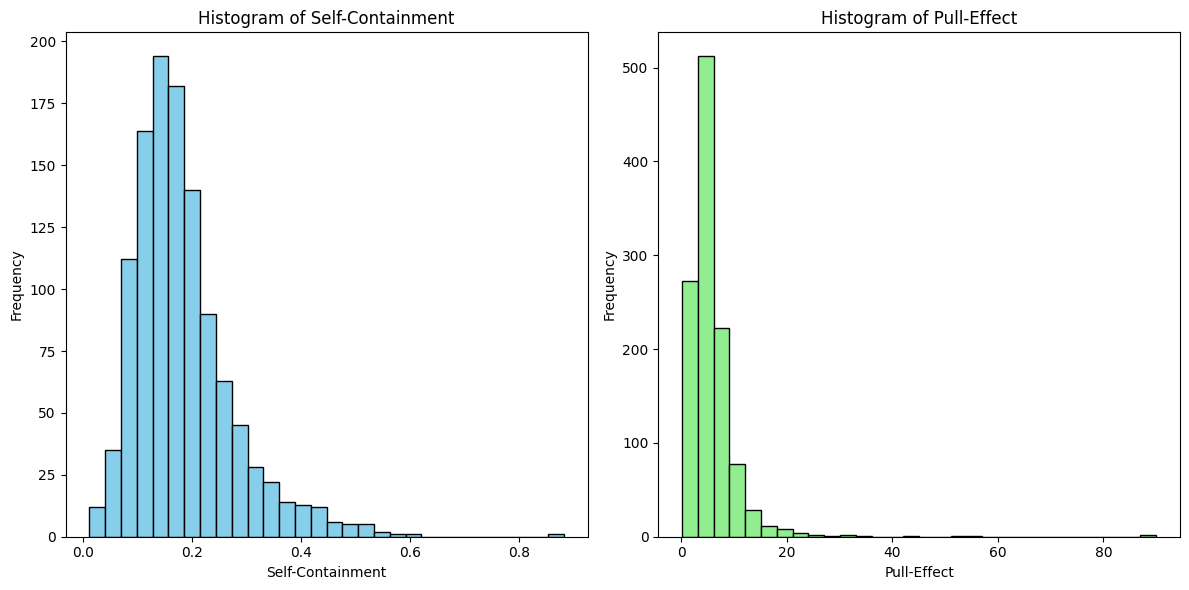

In [ ]:
# Plotting the histogram for 'Self-Containment'
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(merged_df['Self-Containment'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Self-Containment')
plt.xlabel('Self-Containment')
plt.ylabel('Frequency')

# Plotting the histogram for 'Pull-Effect'
plt.subplot(1, 2, 2)
plt.hist(merged_df['Pull-Effect'], bins=30, color='lightgreen', edgecolor='black')
plt.title('Histogram of Pull-Effect')
plt.xlabel('Pull-Effect')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

<ipython-input-52-6214a9869908>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_df['Self-Containment'], shade=True, color='skyblue')
<ipython-input-52-6214a9869908>:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_df['Pull-Effect'], shade=True, color='lightgreen')


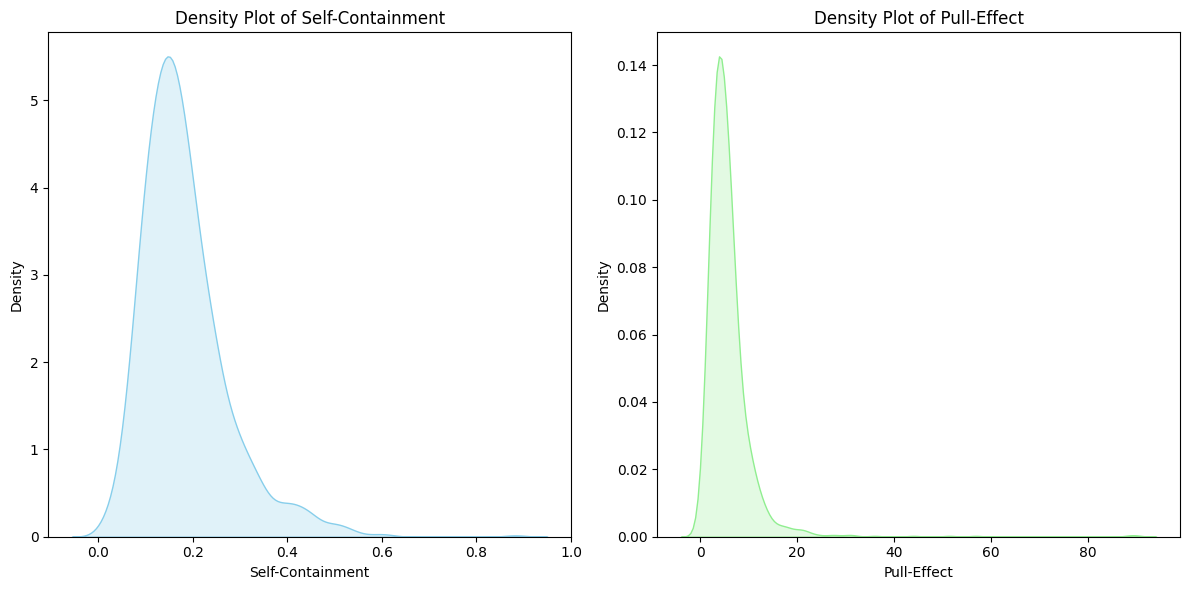

In [ ]:
# Plotting the density plot for 'Self-Containment'
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.kdeplot(merged_df['Self-Containment'], shade=True, color='skyblue')
plt.title('Density Plot of Self-Containment')
plt.xlabel('Self-Containment')
plt.ylabel('Density')

# Plotting the density plot for 'Pull-Effect'
plt.subplot(1, 2, 2)
sns.kdeplot(merged_df['Pull-Effect'], shade=True, color='lightgreen')
plt.title('Density Plot of Pull-Effect')
plt.xlabel('Pull-Effect')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

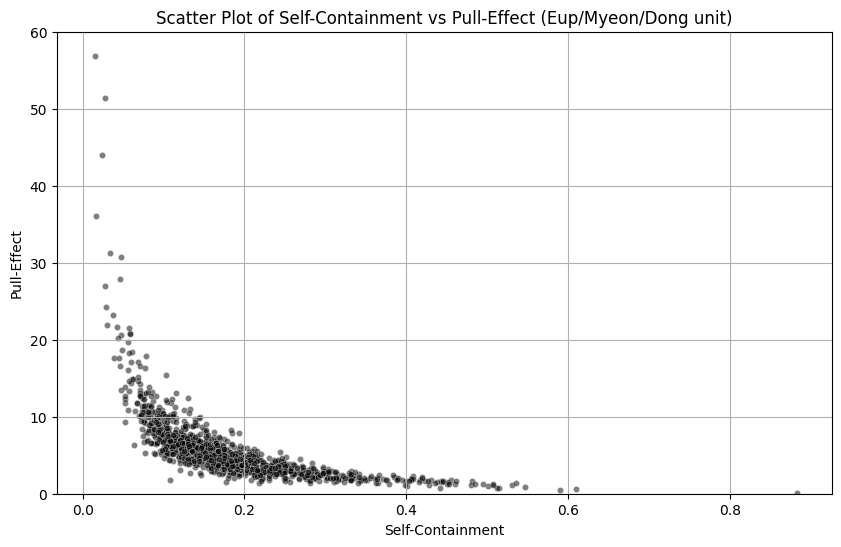

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Self-Containment', y='Pull-Effect', color='black', alpha=0.5, s=20)
plt.title('Scatter Plot of Self-Containment vs Pull-Effect (Eup/Myeon/Dong unit)')
plt.xlabel('Self-Containment')
plt.ylabel('Pull-Effect')
plt.ylim(0, 60)  # Set y-axis range from 0 to 60
plt.grid(True)
plt.show()

In [ ]:
# Calculate Pearson correlation coefficient
correlation, p_value = pearsonr(merged_df['Self-Containment'], merged_df['Pull-Effect'])
print(f"Pearson correlation coefficient: {correlation:.2f}")
print(f"P-value: {p_value:.3f}")

Pearson correlation coefficient: -0.53
P-value: 0.000


### Analysis

In [ ]:
# Pull effect를 오름차순 정렬 후, 그래프 그려보기
# sort pull-effect in ascending order
merged_df = merged_df.sort_values(by='Pull-Effect', ascending=True)
# create the 'inv_rank' column
merged_df['inv_rank'] = range(1, len(merged_df) + 1)
merged_df.head()

,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,full_gu_name,SIDO_NM,SGG_NM,ADMI_NM,inv_rank
575,28720330,0.882588,0.091977,인천광역시 옹진군 백령면,인천광역시 옹진군,인천광역시,옹진군,백령면,1
748,41220250,0.590246,0.464542,경기도 평택시 팽성읍,경기도 평택시,경기도,평택시,팽성읍,2
580,28720380,0.609388,0.663364,인천광역시 옹진군 연평면,인천광역시 옹진군,인천광역시,옹진군,연평면,3
772,41220660,0.441669,0.756580,경기도 평택시 고덕동,경기도 평택시,경기도,평택시,고덕동,4
1041,41590262,0.511642,0.796617,경기도 화성시 남양읍,경기도 화성시,경기도,화성시,남양읍,5


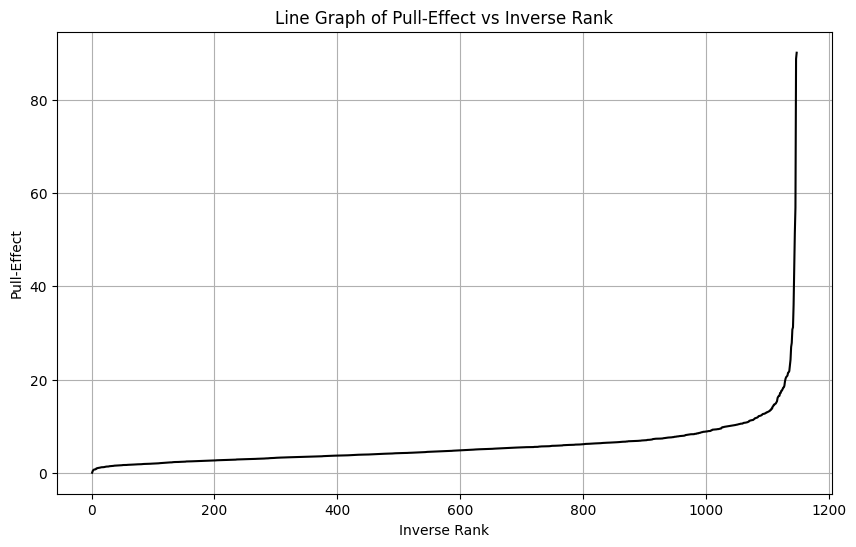

In [ ]:
# draw the line graph having y-axis as Pull-Effect
# Plotting the line graph with adjusted marker size and color
plt.figure(figsize=(10, 6))
plt.plot(
    merged_df['inv_rank'],
    merged_df['Pull-Effect'],
    #marker='o',
    linestyle='-',
    color='k',
    markerfacecolor='black',
    #markeredgecolor='black',
    markersize=1
)
plt.title('Line Graph of Pull-Effect vs Inverse Rank')
plt.xlabel('Inverse Rank')
plt.ylabel('Pull-Effect')
plt.grid(True)
plt.show()

In [ ]:
# rank and residual plot
merged_df.loc[:, 'log_inv_rank'] = np.log(merged_df['inv_rank'])
merged_df.loc[:, 'log_Pull_Effect'] = np.log(merged_df['Pull_Effect'])

X = sm.add_constant(merged_df['log_inv_rank'])
y = merged_df['log_Pull_Effect']

model = sm.OLS(y, X)
results = model.fit()

merged_df.loc[:, 'residuals'] = results.resid
merged_df.loc[:, 'predicted'] = results.predict(X)

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Pull_Effect   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.800
Method:                 Least Squares   F-statistic:                     4598.
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        04:09:45   Log-Likelihood:                -157.64
No. Observations:                1147   AIC:                             319.3
Df Residuals:                    1145   BIC:                             329.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.8667      0.051    -36.620   

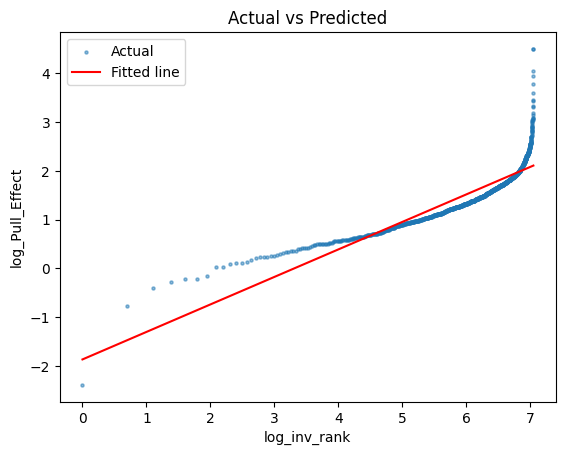

In [ ]:
# line fit plot with rank and Pull-Effect
plt.scatter(merged_df['log_inv_rank'], merged_df['log_Pull_Effect'], s=5, alpha=0.5, label='Actual')
plt.plot(merged_df['log_inv_rank'], merged_df['predicted'], color='red', label='Fitted line')
plt.xlabel('log_inv_rank')
plt.ylabel('log_Pull_Effect')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

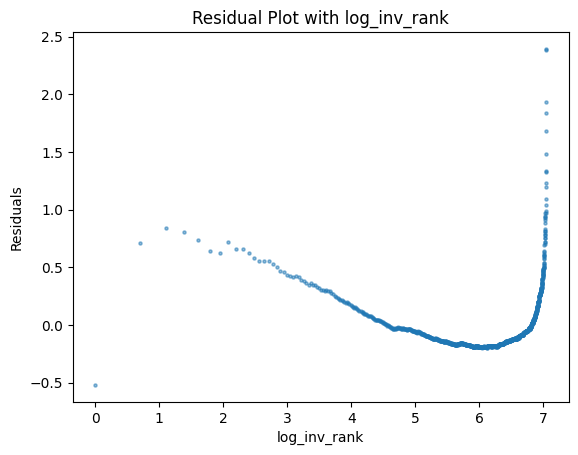

In [ ]:
# Residual plot with rank and residuals
plt.scatter(merged_df['log_inv_rank'], merged_df['residuals'], s=5, alpha=0.5)
plt.xlabel('log_inv_rank')
plt.ylabel('Residuals')
plt.title('Residual Plot with log_inv_rank')
plt.show()

### De Facto Population Data Preprocessing

In [ ]:
pop = pd.read_csv('/content/drive/MyDrive/FMC_Data/LOCAL_PEOPLE_DONG_202303/LOCAL_PEOPLE_DONG_202303.csv', engine='python')

In [ ]:
pop.columns = ['hour_category', 'ADMDONG_CD', 'All_pop', 'M0_9', 'M10_14', 'M15_19', 'M20_24', 'M25_29',
              'M30_34', 'M35_39', 'M40_44', 'M45_49', 'M50_54', 'M55_59', 'M60_64', 'M65_69', 'M70_up', 'F0_9', 'F10_14', 'F15_19', 'F20_24', 'F25_29',
              'F30_34', 'F35_39', 'F40_44', 'F45_49', 'F50_54', 'F55_59', 'F60_64', 'F65_69', 'F70_up', 'novalues']

In [ ]:
pop.head()

,hour_category,ADMDONG_CD,All_pop,M0_9,M10_14,M15_19,M20_24,M25_29,M30_34,M35_39,...,F30_34,F35_39,F40_44,F45_49,F50_54,F55_59,F60_64,F65_69,F70_up,novalues
20230301,0,11500605,12152.9760,314.2590,99.2728,147.1853,125.0909,326.6752,600.0004,840.6125,...,761.3044,767.4585,391.5118,392.7704,377.4368,484.7090,509.1466,419.8514,1164.6325,NaN
20230301,0,11530750,26973.1386,1162.3654,452.8302,684.9993,578.3383,754.6888,901.7400,1170.0395,...,1137.1146,1210.0504,964.0278,1156.5304,962.3229,1291.0357,1142.7477,859.0726,2118.4307,NaN
20230301,0,11140650,9021.9829,307.1753,142.0813,156.1640,228.6131,390.8249,397.4347,403.5795,...,401.4260,437.3798,358.1555,333.1254,313.1381,425.0811,326.8493,198.8057,580.5874,NaN
20230301,0,11200645,26758.6325,1678.3430,465.1377,402.1320,400.6940,536.1799,709.9476,1474.4158,...,1053.7237,1718.0640,1432.6263,1255.1849,963.4359,1030.2344,956.1777,808.9140,1691.4118,NaN
20230301,0,11470610,4062.9669,132.5704,86.6805,108.5833,83.5500,119.4311,149.3410,205.6582,...,148.7245,169.2240,183.6700,162.8845,144.1637,178.7602,172.3166,128.2686,309.6982,NaN


In [ ]:
num_unique_values = pop.index.nunique()
num_unique_values

31

In [ ]:
num_unique_values = pop.hour_category.nunique()
num_unique_values

24

In [ ]:
df_avg_pop = pop.groupby('ADMDONG_CD')['All_pop'].mean().reset_index()

In [ ]:
df_avg_pop

,ADMDONG_CD,All_pop
0,11110515,18490.636366
1,11110530,25468.544788
2,11110540,5994.128247
3,11110550,14177.413914
4,11110560,17815.873594
...,...,...
419,11740650,23320.440226
420,11740660,27011.381976
421,11740685,55860.206574
422,11740690,5006.747107


In [ ]:
# merge 'All_pop' of df_avg_pop dataframe
merged_df = pd.merge(merged_df, df_avg_pop, left_on = 'O_ADMDONG_CD', right_on = 'ADMDONG_CD', how = 'left')
merged_df = merged_df.drop(columns=['ADMDONG_CD'])
merged_df.head()

,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,full_gu_name,SIDO_NM,SGG_NM,ADMI_NM,inv_rank,All_pop
0,28720330,0.882588,0.091977,인천광역시 옹진군 백령면,인천광역시 옹진군,인천광역시,옹진군,백령면,1,NaN
1,41220250,0.590246,0.464542,경기도 평택시 팽성읍,경기도 평택시,경기도,평택시,팽성읍,2,NaN
2,28720380,0.609388,0.663364,인천광역시 옹진군 연평면,인천광역시 옹진군,인천광역시,옹진군,연평면,3,NaN
3,41220660,0.441669,0.756580,경기도 평택시 고덕동,경기도 평택시,경기도,평택시,고덕동,4,NaN
4,41590262,0.511642,0.796617,경기도 화성시 남양읍,경기도 화성시,경기도,화성시,남양읍,5,NaN


In [ ]:
# Transform variables
merged_df.loc[:,'log_All_pop'] = np.log(merged_df['All_pop'])


#### Seoul only with population

In [ ]:
merged_df_Seoul = merged_df[merged_df['SIDO_NM']== "서울특별시"]
merged_df_Seoul

,O_ADMDONG_CD,Self-Containment,Pull-Effect,FULL_NM,full_gu_name,SIDO_NM,SGG_NM,ADMI_NM,inv_rank,All_pop
32,11560540,0.311285,1.526866,서울특별시 영등포구 여의동,서울특별시 영등포구,서울특별시,영등포구,여의동,33,97394.180565
35,11545510,0.177001,1.565108,서울특별시 금천구 가산동,서울특별시 금천구,서울특별시,금천구,가산동,36,62283.192475
43,11590605,0.442501,1.655982,서울특별시 동작구 흑석동,서울특별시 동작구,서울특별시,동작구,흑석동,44,35775.473627
51,11590530,0.351676,1.738092,서울특별시 동작구 상도1동,서울특별시 동작구,서울특별시,동작구,상도1동,52,46946.897287
55,11380690,0.417471,1.752012,서울특별시 은평구 진관동,서울특별시 은평구,서울특별시,은평구,진관동,56,59061.920710
...,...,...,...,...,...,...,...,...,...,...
1129,11110600,0.047808,20.580663,서울특별시 종로구 가회동,서울특별시 종로구,서울특별시,종로구,가회동,1130,7322.607017
1130,11500593,0.058846,20.718058,서울특별시 강서구 화곡8동,서울특별시 강서구,서울특별시,강서구,화곡8동,1131,31000.180086
1131,11170530,0.059172,20.896157,서울특별시 용산구 남영동,서울특별시 용산구,서울특별시,용산구,남영동,1132,17314.244466
1142,11470610,0.023980,44.003072,서울특별시 양천구 신월6동,서울특별시 양천구,서울특별시,양천구,신월6동,1143,4130.358684


In [ ]:
# Transform variables
merged_df_Seoul.loc[:,'log_All_pop'] = np.log(merged_df_Seoul['All_pop'])
merged_df_Seoul.loc[:,'log_Pull_Effect'] = np.log(merged_df_Seoul['Pull-Effect'])

# Replace drop any rows containing NaN
merged_df_Seoul = merged_df_Seoul.dropna()

# Add a constant to the independent values
X = sm.add_constant(merged_df_Seoul['log_All_pop'])

# Create a model
model = sm.OLS(merged_df_Seoul['log_Pull_Effect'], X)

# Fit the model
results = model.fit()

# Get the beta coefficient
beta = results.params['log_All_pop']

print("The beta coefficient is", beta)

The beta coefficient is -0.49763476470087625


In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Pull_Effect   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     142.9
Date:                Thu, 10 Oct 2024   Prob (F-statistic):           1.67e-28
Time:                        03:44:15   Log-Likelihood:                -234.00
No. Observations:                 416   AIC:                             472.0
Df Residuals:                     414   BIC:                             480.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.6486      0.416     15.972      

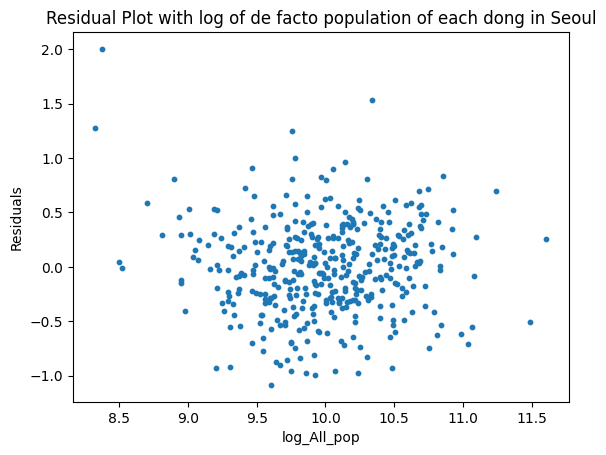

In [ ]:
import matplotlib.pyplot as plt

# Calculate the residuals
merged_df_Seoul['residuals'] = results.resid

# Create a scatter plot
plt.scatter(merged_df_Seoul['log_All_pop'], merged_df_Seoul['residuals'], s=10)
plt.xlabel('log_All_pop')
plt.ylabel('Residuals')
plt.title('Residual Plot with log of de facto population of each dong in Seoul')
plt.show()

<ipython-input-27-183d48b0c578>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_Seoul['predicted'] = results.predict(X)


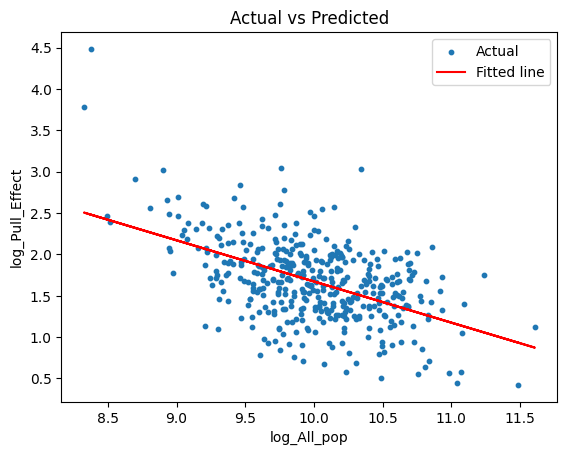

In [ ]:
# Calculate predicted values
merged_df_Seoul['predicted'] = results.predict(X)

plt.scatter(merged_df_Seoul['log_All_pop'], merged_df_Seoul['log_Pull_Effect'], s=10, label='Actual')
plt.plot(merged_df_Seoul['log_All_pop'], merged_df_Seoul['predicted'], color='red', label='Fitted line')
plt.xlabel('log_All_pop')
plt.ylabel('log_Pull_Effect')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [4]:
#@title exploring: The two outliers on the left top
df = pd.read_csv("/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/aggregated_Dong-Dong count_2023_03_ver2.csv")

In [8]:
df.head()

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,CNT_3,CNT_24567,RT-NonWork_CNT,RT-Work_CNT
0,11110515,11110515,13045.84,52744.40,139766.81,126720.97,-73976.57
1,11110515,11110530,11888.65,12368.02,108223.86,96335.21,-83967.19
2,11110515,11110540,1498.43,2483.60,27594.13,26095.70,-23612.10
3,11110515,11110550,1207.86,12662.17,14987.79,13779.93,-1117.76
4,11110515,11110560,1033.45,12025.93,7057.94,6024.49,6001.44


In [20]:
# 양천구 신월6동이 destination인 데이터 filtering
df_11470610 = df.loc[df['D_ADMDONG_CD'] == 11470610, :]
# 1: Going to Work, 2 : Going to School, 3: Going back to home, 4: Shopping, 5: Sightseeing/Tourism, 6: Hospital, 7: Others
columns_to_sum = ['CNT_1', 'CNT_3', 'CNT_24567', 'RT-NonWork_CNT', 'RT-Work_CNT']
column_sums = df_11470610[columns_to_sum].sum()
column_sums

,0
CNT_1,28263.39
CNT_3,66807.67
CNT_24567,114919.72
RT-NonWork_CNT,88618.25
RT-Work_CNT,-21810.58


In [17]:
df_11470610.groupby(['D_ADMDONG_CD'])

,O_ADMDONG_CD,D_ADMDONG_CD,CNT_1,CNT_3,CNT_24567,RT-NonWork_CNT,RT-Work_CNT
232,11110515,11470610,0.00,4.5,6.70,6.70,-2.20
2704,11110530,11470610,0.00,182.2,61.55,61.55,120.65
5045,11110540,11470610,0.00,0.0,2.88,2.88,-2.88
6702,11110550,11470610,0.00,0.0,5.32,5.32,-5.32
8521,11110560,11470610,0.00,4.5,18.47,18.47,-13.97
...,...,...,...,...,...,...,...
3120564,47820250,11470610,0.00,0.0,2.56,2.56,-2.56
3160200,48240250,11470610,0.00,0.0,3.50,3.50,-3.50
3190618,48880250,11470610,0.00,0.0,3.65,3.65,-3.65
3195624,50110540,11470610,0.00,0.0,3.58,3.58,-3.58


In [ ]:
#@title rank and residual plot
merged_df_Seoul.loc[:, 'log_inv_rank'] = np.log(merged_df_Seoul['inv_rank'])
X = sm.add_constant(merged_df_Seoul['log_inv_rank'])
y = merged_df_Seoul['log_Pull_Effect']

model = sm.OLS(y, X)
results = model.fit()

merged_df_Seoul.loc[:, 'residuals'] = results.resid
merged_df_Seoul.loc[:, 'predicted'] = results.predict(X)

In [ ]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        log_Pull_Effect   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                     1454.
Date:                Thu, 10 Oct 2024   Prob (F-statistic):          1.53e-137
Time:                        03:49:03   Log-Likelihood:                 17.738
No. Observations:                 416   AIC:                            -31.48
Df Residuals:                     414   BIC:                            -23.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.6237      0.113    -23.140   

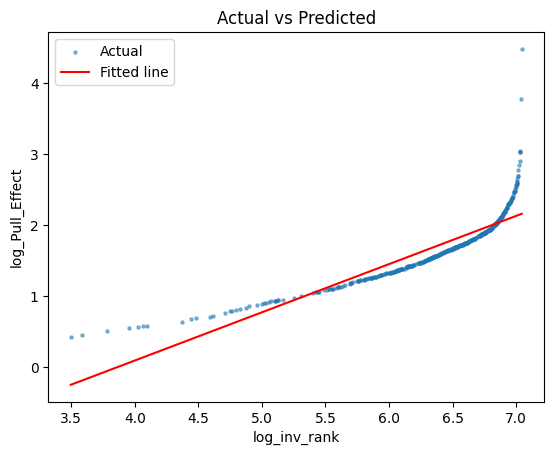

In [ ]:
# line fit plot with rank and Pull-Effect
plt.scatter(merged_df_Seoul['log_inv_rank'], merged_df_Seoul['log_Pull_Effect'], s=5, alpha=0.5, label='Actual')
plt.plot(merged_df_Seoul['log_inv_rank'], merged_df_Seoul['predicted'], color='red', label='Fitted line')
plt.xlabel('log_inv_rank')
plt.ylabel('log_Pull_Effect')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

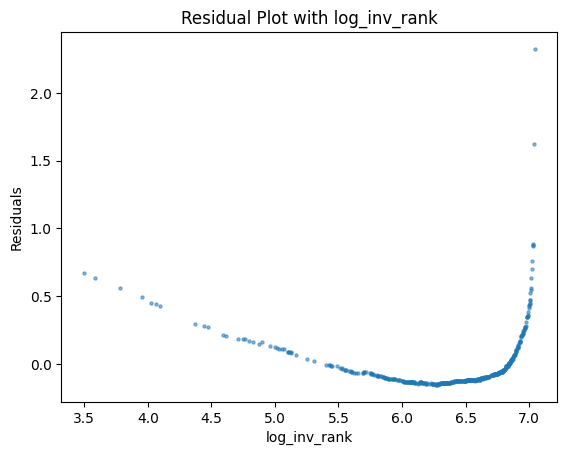

In [ ]:
# Residual plot with rank and residuals
plt.scatter(merged_df_Seoul['log_inv_rank'], merged_df_Seoul['residuals'], s=5, alpha=0.5)
plt.xlabel('log_inv_rank')
plt.ylabel('Residuals')
plt.title('Residual Plot with log_inv_rank')
plt.show()

In [ ]:
merged_df.to_excel("/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/AllMetropolitan_dong_Analysis_20241010.xlsx")

In [ ]:
merged_df_Seoul.to_excel("/content/drive/MyDrive/FMC_Data/M_B_dong_Aggregated_noNan/Seoul_dong_Analysis_20241010.xlsx")